In [1]:
# Import SparkSession
from pyspark.sql import SparkSession

# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("Diabetes prediction") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

In [3]:
#Pima Indians Diabetes Database
#Predict the onset of diabetes based on diagnostic measures
#UCI Machine Learning
#The Applied options are for CSV files
df = spark.read.format("csv") \
     .option("inferSchema","true") \
     .option("header","true") \
     .option("sep",",") \
     .load("ds_diabetes.csv")


In [4]:
df.head(5)

[Row(Pregnancies=6, Glucose=148, BloodPressure=72, SkinThickness=35, Insulin=0, BMI=33.6, DiabetesPedigreeFunction=0.627, Age=50, Outcome=1),
 Row(Pregnancies=1, Glucose=85, BloodPressure=66, SkinThickness=29, Insulin=0, BMI=26.6, DiabetesPedigreeFunction=0.351, Age=31, Outcome=0),
 Row(Pregnancies=8, Glucose=183, BloodPressure=64, SkinThickness=0, Insulin=0, BMI=23.3, DiabetesPedigreeFunction=0.672, Age=32, Outcome=1),
 Row(Pregnancies=1, Glucose=89, BloodPressure=66, SkinThickness=23, Insulin=94, BMI=28.1, DiabetesPedigreeFunction=0.167, Age=21, Outcome=0),
 Row(Pregnancies=0, Glucose=137, BloodPressure=40, SkinThickness=35, Insulin=168, BMI=43.1, DiabetesPedigreeFunction=2.288, Age=33, Outcome=1)]

In [ ]:
!pip install pyspark_dist_explore

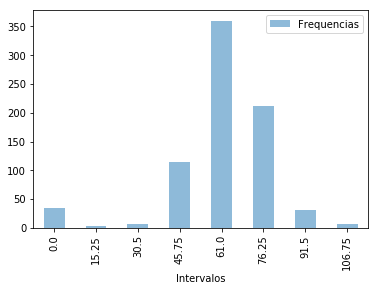

In [52]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import pandas as pd

# Doing the heavy lifting in Spark. We could leverage the `histogram` function from the RDD api

preg_histogram = df.select('BloodPressure').rdd.flatMap(lambda x: x).histogram(8)
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*preg_histogram)), 
    columns=['Intervalos', 'Frequencias']
).set_index(
    'Intervalos'
).plot(kind='bar',alpha=0.5);


In [4]:
from collections import defaultdict
data_types = defaultdict(list)
for entry in df.schema.fields:
  data_types[str(entry.dataType)].append(entry.name)


In [5]:
data_types

defaultdict(list,
            {'IntegerType': ['Pregnancies',
              'Glucose',
              'BloodPressure',
              'SkinThickness',
              'Insulin',
              'Age',
              'Outcome'],
             'DoubleType': ['BMI', 'DiabetesPedigreeFunction']})

In [6]:
display(df.limit(5))

DataFrame[Pregnancies: int, Glucose: int, BloodPressure: int, SkinThickness: int, Insulin: int, BMI: double, DiabetesPedigreeFunction: double, Age: int, Outcome: int]

In [7]:
print("Dataset dimension: (",df.count(),",",len(df.columns),")")

Dataset dimension: ( 768 , 9 )


In [9]:
display(df.groupby('Outcome').count())

DataFrame[Outcome: int, count: bigint]


In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [11]:
strings_used = ["Pregnancies"]

In [ ]:
#Referencia Hien Luu - Beginning Apache Spark 2_ With Resilient Distributed Datasets, Spark SQL, Structured Streaming and Spark Machine Learning library-Apress (2018)
"""
The OneHotEncoder transformer is commonly used when working with numeric
categorical values. If the categorical values are of string type, then first apply the
StringIndexer estimator to convert them to a numerical type. The OneHotEncoder
transformer essentially maps a numeric categorical value into a binary vector to
purposely remove the implicit ranking of the numeric categorical values.
"""
"""
Estimator: StringIndexer
Data Transformation algorithms

"""

In [12]:
stage_string = [StringIndexer(inputCol= c, outputCol = c+"_string_encoded") for c in strings_used]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded",outputCol= c+ "_one_hot") for c in strings_used]
ppl = Pipeline(stages= stage_string + stage_one_hot)
df = ppl.fit(df).transform(df)

In [13]:
df.head(5)

[Row(Pregnancies=6, Glucose=148, BloodPressure=72, SkinThickness=35, Insulin=0, BMI=33.6, DiabetesPedigreeFunction=0.627, Age=50, Outcome=1, Pregnancies_string_encoded=6.0, Pregnancies_one_hot=SparseVector(16, {6: 1.0})),
 Row(Pregnancies=1, Glucose=85, BloodPressure=66, SkinThickness=29, Insulin=0, BMI=26.6, DiabetesPedigreeFunction=0.351, Age=31, Outcome=0, Pregnancies_string_encoded=0.0, Pregnancies_one_hot=SparseVector(16, {0: 1.0})),
 Row(Pregnancies=8, Glucose=183, BloodPressure=64, SkinThickness=0, Insulin=0, BMI=23.3, DiabetesPedigreeFunction=0.672, Age=32, Outcome=1, Pregnancies_string_encoded=8.0, Pregnancies_one_hot=SparseVector(16, {8: 1.0})),
 Row(Pregnancies=1, Glucose=89, BloodPressure=66, SkinThickness=23, Insulin=94, BMI=28.1, DiabetesPedigreeFunction=0.167, Age=21, Outcome=0, Pregnancies_string_encoded=0.0, Pregnancies_one_hot=SparseVector(16, {0: 1.0})),
 Row(Pregnancies=0, Glucose=137, BloodPressure=40, SkinThickness=35, Insulin=168, BMI=43.1, DiabetesPedigreeFuncti

In [14]:
#Referencia Hien Luu - Beginning Apache Spark 2_ With Resilient Distributed Datasets, Spark SQL, Structured Streaming and Spark Machine Learning library-Apress (2018)
#Transformer: VectorAssembler
from pyspark.ml.feature import VectorAssembler
features = ['Pregnancies_one_hot','Glucose','BloodPressure',
'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
vector_assembler = VectorAssembler(inputCols = features, outputCol= "features")
data_training_and_test = vector_assembler.transform(df)

In [19]:
data_training_and_test.head(5)

[Row(Pregnancies=6, Glucose=148, BloodPressure=72, SkinThickness=35, Insulin=0, BMI=33.6, DiabetesPedigreeFunction=0.627, Age=50, Outcome=1, Pregnancies_string_encoded=6.0, Pregnancies_one_hot=SparseVector(16, {6: 1.0}), features=SparseVector(23, {6: 1.0, 16: 148.0, 17: 72.0, 18: 35.0, 20: 33.6, 21: 0.627, 22: 50.0})),
 Row(Pregnancies=1, Glucose=85, BloodPressure=66, SkinThickness=29, Insulin=0, BMI=26.6, DiabetesPedigreeFunction=0.351, Age=31, Outcome=0, Pregnancies_string_encoded=0.0, Pregnancies_one_hot=SparseVector(16, {0: 1.0}), features=SparseVector(23, {0: 1.0, 16: 85.0, 17: 66.0, 18: 29.0, 20: 26.6, 21: 0.351, 22: 31.0})),
 Row(Pregnancies=8, Glucose=183, BloodPressure=64, SkinThickness=0, Insulin=0, BMI=23.3, DiabetesPedigreeFunction=0.672, Age=32, Outcome=1, Pregnancies_string_encoded=8.0, Pregnancies_one_hot=SparseVector(16, {8: 1.0}), features=SparseVector(23, {8: 1.0, 16: 183.0, 17: 64.0, 20: 23.3, 21: 0.672, 22: 32.0})),
 Row(Pregnancies=1, Glucose=89, BloodPressure=66, 

In [15]:
#Etapa de entrenamiento
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
(training_data, test_data) = data_training_and_test.randomSplit([0.7, 0.3], 2017)
rf = RandomForestClassifier(labelCol = "Outcome", 
                        featuresCol = "features", numTrees = 20)
rf_model = rf.fit(training_data)
predictions = rf_model.transform(test_data)
evaluator= BinaryClassificationEvaluator(labelCol = "Outcome", rawPredictionCol="probability", metricName= "areaUnderROC")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:",accuracy*100)

Accuracy: 80.80255828347421


In [16]:
import pandas as pd
importance_list = pd.Series(rf_model.featureImportances.values)
sorted_imp = importance_list.sort_values(ascending= False)
kept = list((sorted_imp[sorted_imp > 0.03]).index)

In [17]:
#Etapa de Test
from pyspark.ml.feature import VectorSlicer
vector_slicer = VectorSlicer(inputCol= "features", indices= kept, outputCol= "feature_subset")
with_selected_feature = vector_slicer.transform(training_data)
rf_modified = RandomForestClassifier(numTrees=20, labelCol = "Outcome", featuresCol="feature_subset")
test_data = vector_slicer.transform(test_data)
prediction_modified = rf_modified.fit(with_selected_feature).transform(test_data)
evaluator_modified = BinaryClassificationEvaluator(labelCol = "Outcome",rawPredictionCol="probability", metricName= "areaUnderROC")
accuracy = evaluator_modified.evaluate(prediction_modified)
print("Accuracy: ",accuracy*100)

Accuracy:  81.63296884670925
